#### toy grover search
&nbsp; &nbsp; &nbsp; following Nielsen-Chuang ( chapter 6.1 ) and Hidary ( chapter 8.6 )

In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def int2bit( n, k ):
    assert n < 2 ** k
    b = [ 0 if b == '0' else 1 for b in bin( n )[ 2 : ] ]
    b = ( k - len( b ) ) * [ 0 ] + b
    return b # the binary expansion of n, as a list of k bits

In [3]:
def bit2int( b ):
    n = sum( [ bn * 2 ** n for n, bn in enumerate( reversed( b ) ) ] )
    return n

In [4]:
def reflection( q ):
    R = [ cirq.Z.controlled( len( q ) - 1 ).on( * q ) ]
    return R # a gate in a list

In [5]:
def oracle_gates( q, m ): # only the oracle knows m
    b = int2bit( m, len( q ) ) # the bits of m
    Xs = [ cirq.X( qn ) for qn, bn in zip( q, b ) if bn == 0 ]
    R = reflection( q )
    return Xs + R + Xs # gates in a list

In [6]:
def diffusion_gates( q ):
    Hs = [ cirq.H.on_each( q ) ]
    Xs = [ cirq.X.on_each( q ) ]
    R = reflection( q )
    return Hs + Xs + R + Xs + Hs # gates in a list

In [7]:
def grover_circuit( q, oracle, diffuser, size ):
    Hs = [ cirq.H.on_each( q ) ]
    rotation = oracle + diffuser # two reflections make a rotation
    rotations = size * rotation
    measure = [ cirq.measure( qn, key = str( n ) ) for n, qn in enumerate( q ) ]
    return cirq.Circuit( Hs + rotations + measure )

In [8]:
def simulate( q, program, repetitions ):
    result = cirq.Simulator( ).run( program = program, repetitions = repetitions )
    result = [ result.measurements[ str( n ) ] for n in range( len( q ) ) ]
    return np.array( result ).squeeze( )

In [9]:
def plot( measurement, k ):
    count = np.zeros( 2 ** k, dtype = 'float' )
    for n in measurement : count[ n ] += 1
    prob = count / np.sum( count )
    fig, axis = plt.subplots( )
    axis.set_facecolor( 'black' )
    axis.tick_params( colors = 'white' )
    axis.set_xlabel( 'measurement', color = 'white', size = '14' )
    axis.set_ylabel( 'probability', color = 'white', size = '14' )
    axis.plot( range( 2 ** k ), prob, color = 'white', marker = '.', linestyle = 'None' )
    fig.set_figwidth( 11 )
    fig.set_figheight( 6 )
    plt.show( )

In [10]:
def display( circuit, result, size, m ):
    [ k, repetitions ] = result.shape
    sqrt = int( 3.14 / 4 * 2 ** ( k / 2 ) ) 
    measurement = np.array( [ bit2int( result[ : , n ] ) for n in range( repetitions ) ] )
    print( 'grover circuit simulation\n' )
    print( f'qubits        { k }' )
    print( f'optimal size  { sqrt } rotations' )
    print( f'actual  size  { size } rotations' )
    print( f'looking for   { m } among the numbers { 0 }, { 1 }, ..., { 2 ** k - 1 }\n' )
    if repetitions < 300 : print( f'measurements\n{ measurement }' )
    if k < 20 : plot( measurement, k )
    if size <  3 : print( f'\ncircuit diagram\n{ circuit }' ) 

grover circuit simulation

qubits        4
optimal size  3 rotations
actual  size  2 rotations
looking for   6 among the numbers 0, 1, ..., 15

measurements
[ 6  6  6  6  6  6  6 14  6  6 13  6  6  6  6  6  6 13  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  7  6  6  6  6  6  1  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6 11  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6]


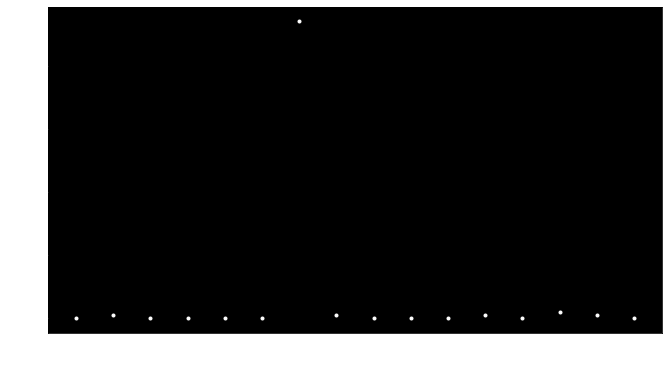


circuit diagram
0: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('0')───
              │               │               │               │
1: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('1')───
              │               │               │               │
2: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('2')───
              │               │               │               │
3: ───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───M('3')───


In [13]:
m = 6 # what we hope to measure
k = 4 # number of qubits
q = cirq.LineQubit.range( k )
oracle = oracle_gates( q, m )
diffuser = diffusion_gates( q )

size = int( 3.14 / 4 * 2 ** ( k / 2 ) ) # optimal size of the circuit, in rotations
size = 2                                # try smaller circuit
grover = grover_circuit( q, oracle, diffuser, size )

repetitions = 100
result = simulate( q, grover, repetitions )
display( grover, result, size, m )

grover circuit simulation

qubits        16
optimal size  200 rotations
actual  size  100 rotations
looking for   11111 among the numbers 0, 1, ..., 65535

measurements
[16208 11111 28691 11111 35272 38820 11111 15106 11111 11111 11111  2778
 25440  7308 11111   973 28442 57783 11111 11111 37043 20051 46605 11111
 11111 43238 38534 11111 43170 11111 64437 11111 35973 11111 19479 30878
 11111 57197 64156  9909 62789 11111 11111 38889 11111 40462 54694 11111
 11111 11111]


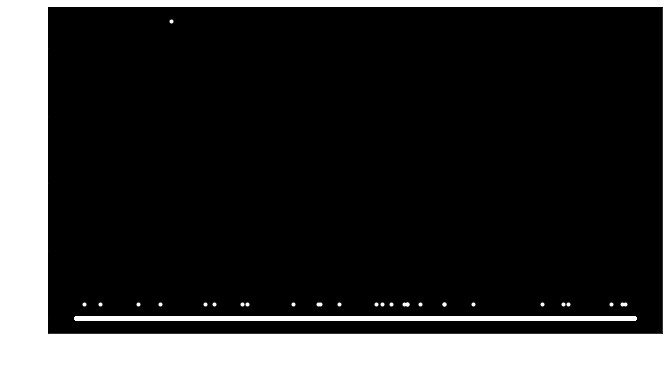

In [12]:
m = 11111
k = 16
q = cirq.LineQubit.range( k )
oracle = oracle_gates( q, m )
diffuser = diffusion_gates( q )

size = 100
grover = grover_circuit( q, oracle, diffuser, size )

repetitions = 50
result = simulate( q, grover, repetitions )
display( grover, result, size, m )